In [1]:
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/')
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/utils/')
from data_loading import *
from hit import Hit
from track3D import Track3D
from track import Track
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import sys
from tqdm import tqdm

plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': [r'\usepackage{amsmath}'],
    'figure.dpi': 140
})


In [2]:
# later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing
file_path = '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/geant4/data_MIP.root'

branch_list = ['E', 'Edep', 'pdg', 'EcalEdep',
               'layerID', 'barID', 'Nhits', 'tx', 'ty', 'x0', 'y0', 'n_sec',
               'ProcessID', 'x_decay', 'y_decay', 'z_decay', 'size_XY', 'size_Z']
with uproot.open(file_path) as tree:
        hits_dict = tree['events'].arrays(branch_list, library="np")

df_hits = pd.DataFrame.from_dict(hits_dict)

In [3]:
from parameters import *

def get_hits(row):
    return [[row['barID'][i], row['layerID'][i], row['EcalEdep'][i], row['ProcessID']] for i in range(len(row['barID']))
            if row['EcalEdep'][i] > 0 and (row['pdg'][i] == -5 or row['pdg'][i] == 406 or row['pdg'][i] == 407)]

def create_tracks(df, plot=False):
    tracks = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        hits = get_hits(row)
        if len(hits) > 0:
            hitsX = [Hit([bar, (layer-1)/2 + 1], True, 0, 0, e) for (bar, layer, e, t) in hits if layer % 2 == 1]
            hitsY = [Hit([bar, layer/2 + 1], False, 0, 0, e) for (bar, layer, e, t) in hits if layer % 2 == 0]
            
            # get track parameters
            if len(hitsX) > 1 and len(hitsY) > 1:
                track = Track3D()
                track.x = Track(hitsX)
                track.y = Track(hitsY)
                tracks.append(track)

    return tracks


In [4]:
tracks = create_tracks(df_hits)
# import line_profiler
# %reload_ext line_profiler
# %lprun -f create_tracks create_tracks(df_hits.head(100))


100%|██████████| 50000/50000 [12:29<00:00, 66.69it/s]


####### Track # 11645


Text(0.5, 0, '$Edep$ [GeV]')

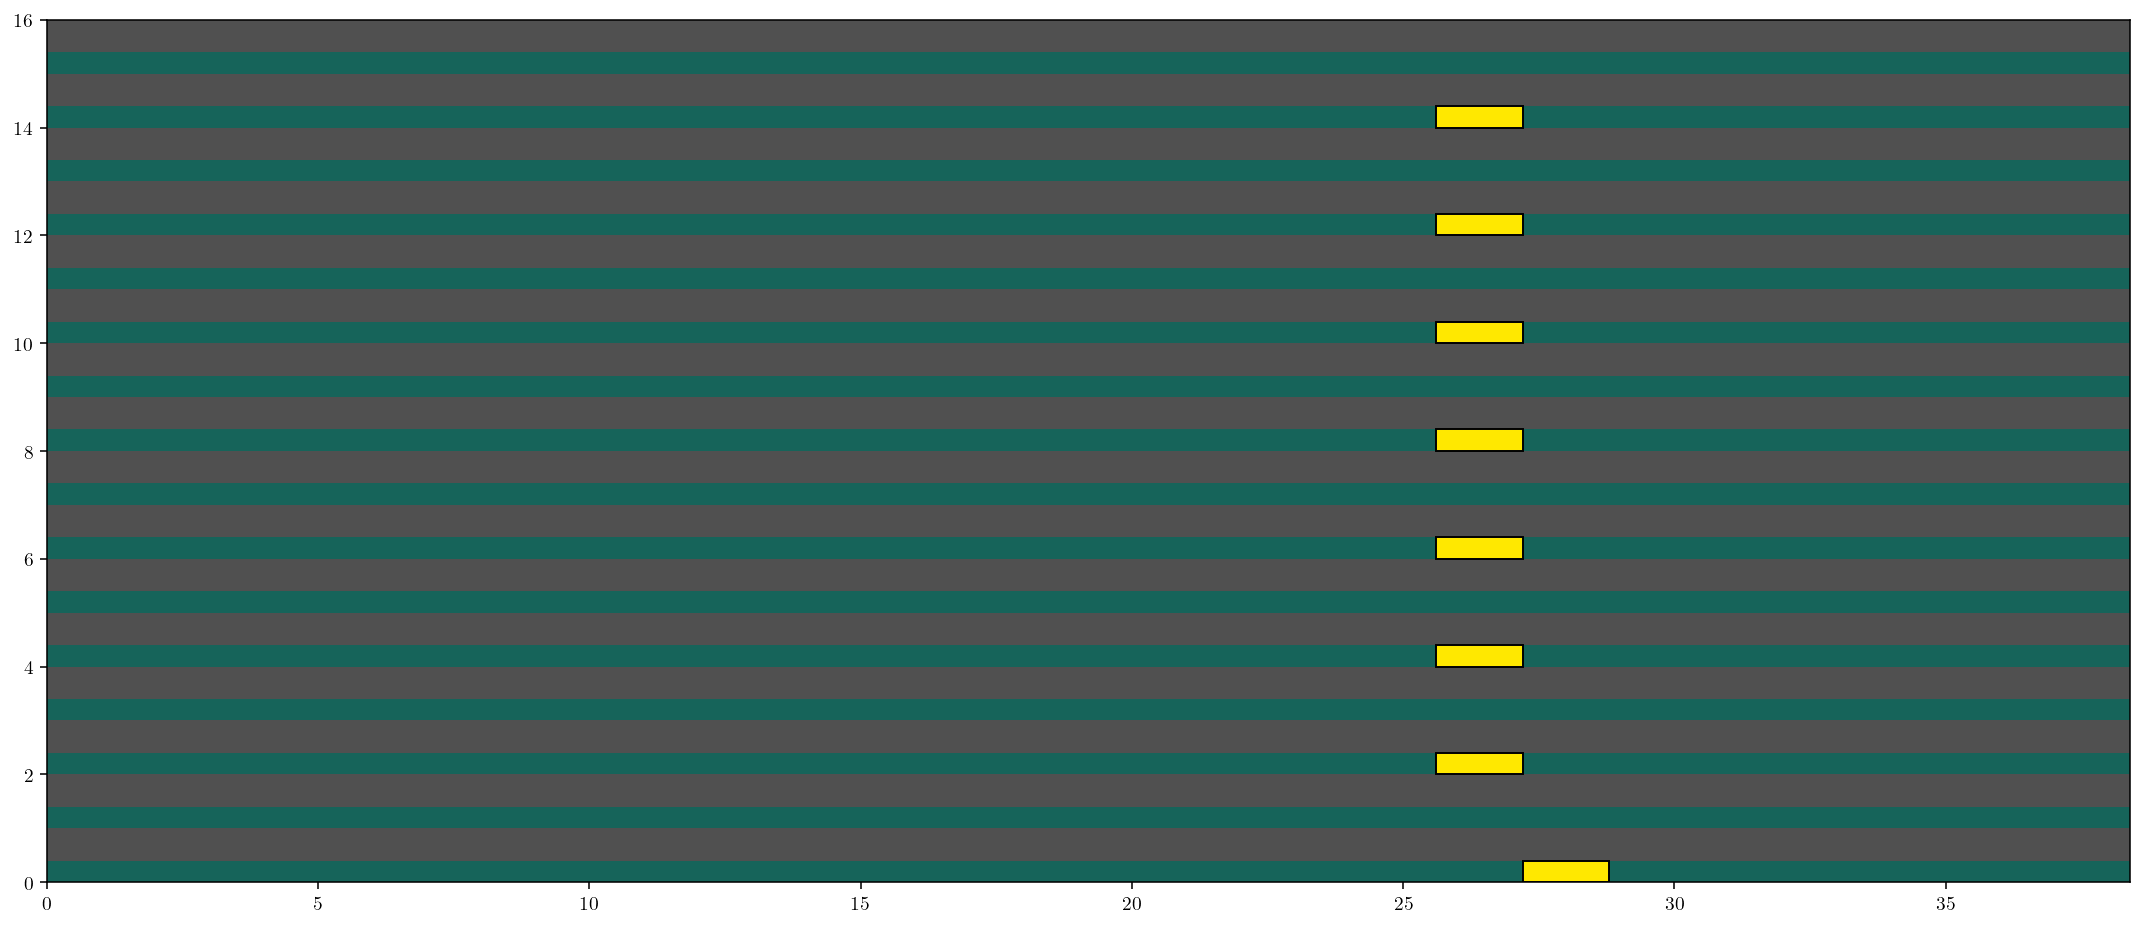

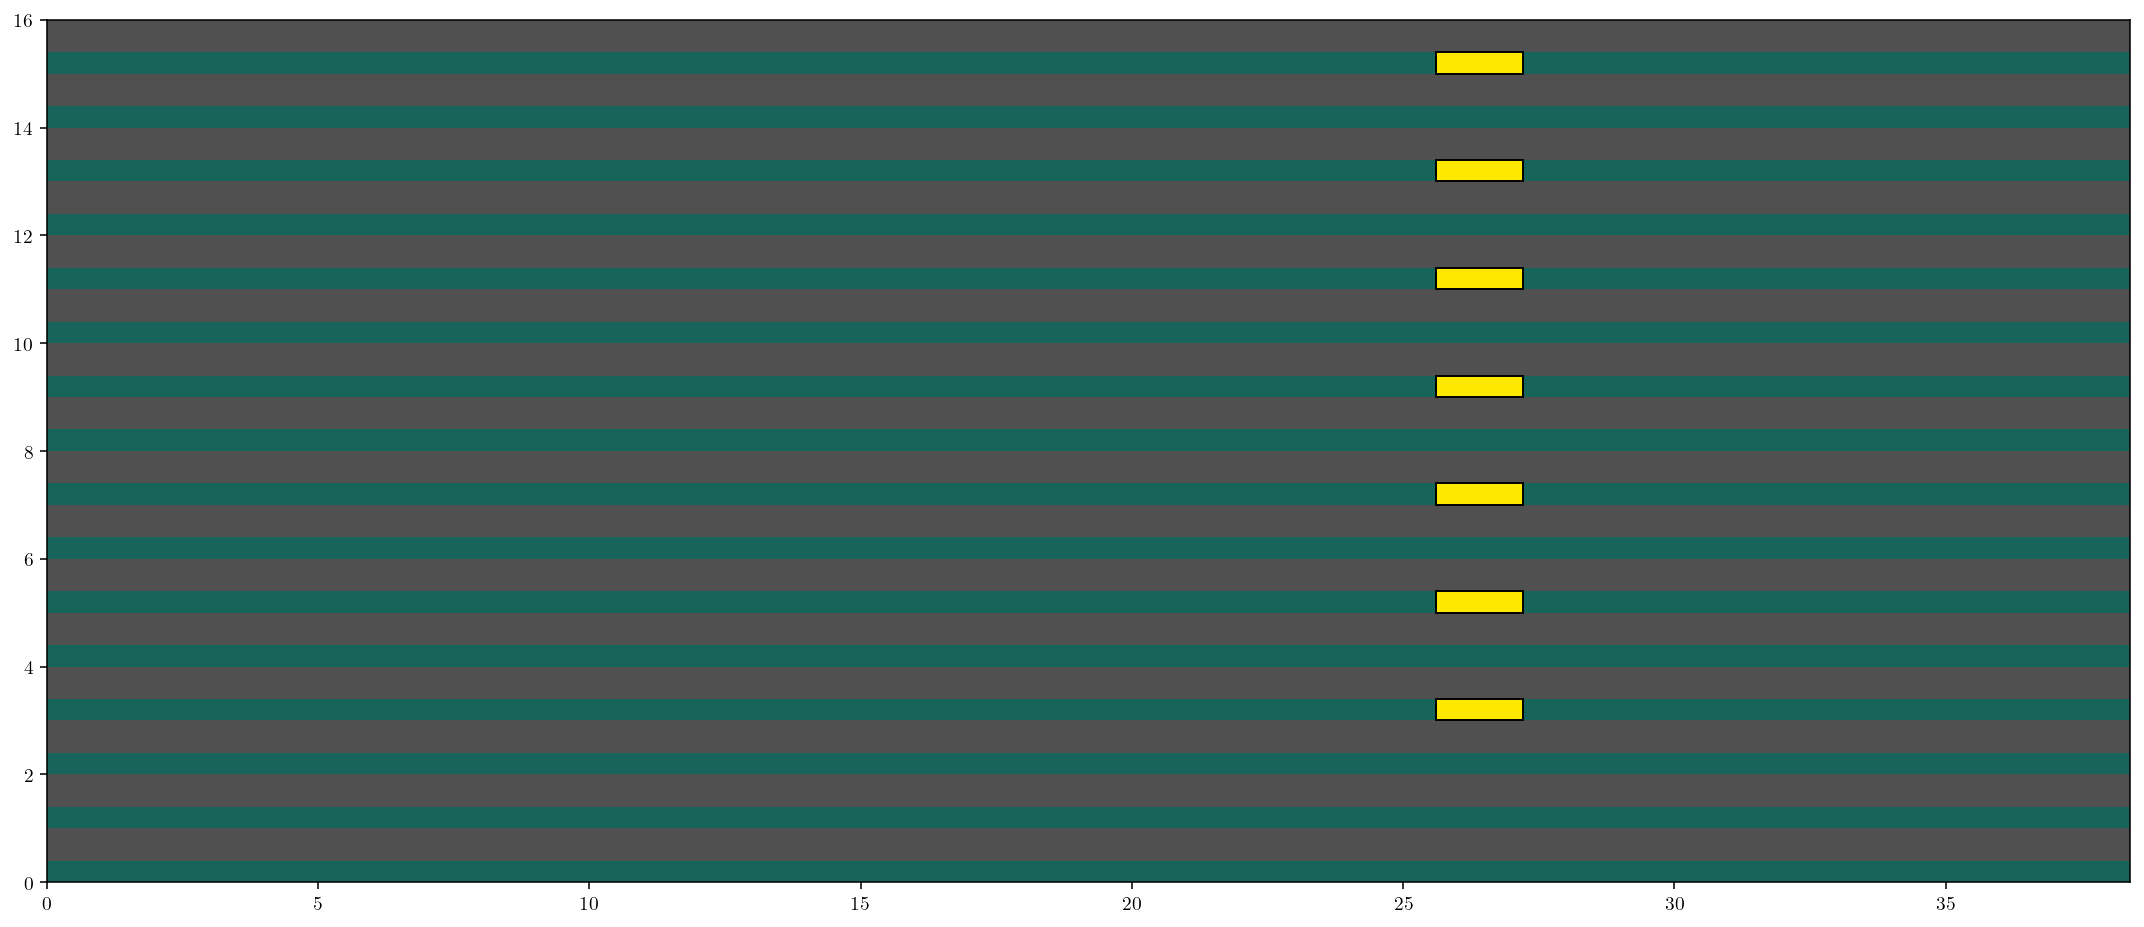

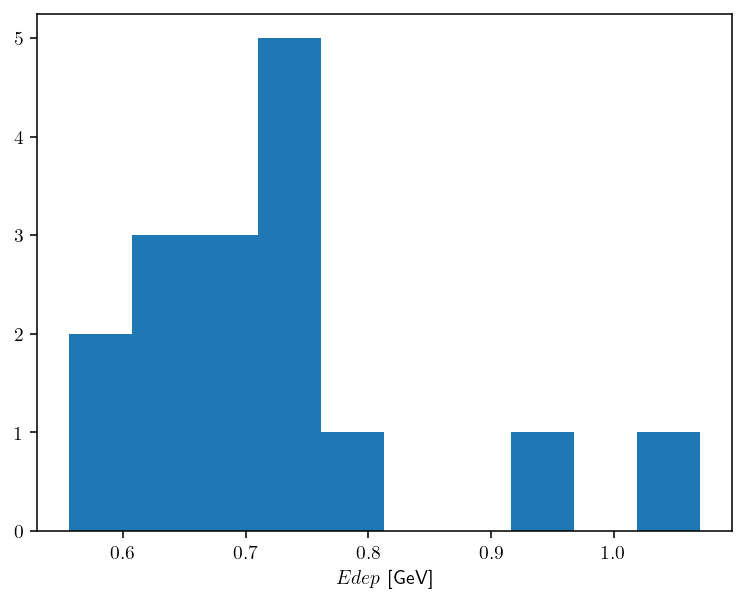

In [5]:
from track_reconstruction import plot_hits
i = np.random.randint(0, len(tracks))
print('####### Track # {}'.format(i))
t = tracks[i]
all_hits = t.x.hits.copy()
all_hits.extend(t.y.hits)
fig1, axs1 = plot_hits(all_hits, True)
fig2, axs2 = plot_hits(all_hits, False)

edeps = [h.value for h in t.x.hits]
edeps.extend([h.value for h in t.y.hits])
plt.figure()
plt.hist(edeps, bins = 10)
plt.xlabel('$Edep$ [GeV]')


16
MAX: E=0.66000
MEAN: E=1.32749


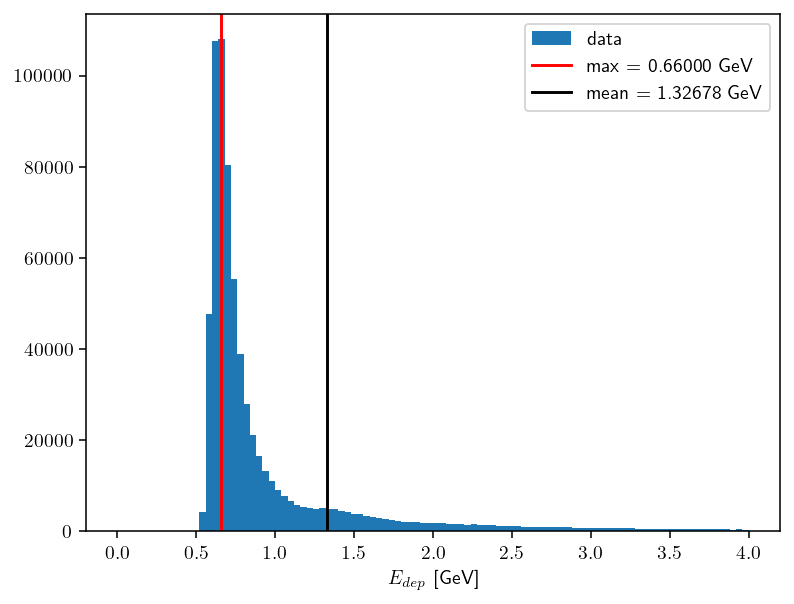

In [6]:
edeps = []
for t in tracks:
    edeps.extend([h.value for h in t.x.hits])
    edeps.extend([h.value for h in t.y.hits])

plt.figure()
h, xs, _ = plt.hist(edeps, bins = 100, range = [0, 4], label = 'data')
plt.xlabel('$E_{dep}$ [GeV]')
# plt.yscale('log')

max_arg = np.argmax(h)
print(max_arg)
xs = np.array(xs) + (xs[1] - xs[0])/2
print('MAX: E={:.5f}'.format(xs[max_arg]))
print('MEAN: E={:.5f}'.format(np.mean(edeps)))
plt.axvline(xs[max_arg], 0, 1, c='r', label='max = 0.66000 GeV')
plt.axvline(np.mean(edeps), 0, 1, c='k', label='mean = 1.32678 GeV')
plt.legend()